## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GRU, Reshape
from tensorflow.python.keras import utils
from keras.utils import to_categorical
from numpy import load
import io

### Load Spectrogram and Label Numpy Array from npy file

In [ ]:
from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load Spectrogam array
X = load(io.BytesIO(uploaded['mel_specs.npy']))

In [ ]:
# load Labels array
y = load(io.BytesIO(uploaded['labels.npy']))

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

In [ ]:
X_test.shape

(200, 128, 660)

In [ ]:
X_train.shape

(799, 128, 660)

#### Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

#### One hot encoding our labels

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


### Define the Keras Tuner Hypermodels

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=hp.Int(name='units_1',
            min_value=16, max_value=128, step=16),
                kernel_size=(3,3),
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=(2,4)))
        model.add(
            Conv2D(
                filters=hp.Int(name='units_2',
            min_value=16, max_value=128, step=16),
                kernel_size=(3,3),
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=(2,4)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int(name='dense_units',
            min_value=16, max_value=128, step=16), activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

### Setting up Random Search Optimization

In [ ]:
NUM_CLASSES = 10
INPUT_SHAPE = (128, 660, 1)
SEED = 2
HYPERBAND_MAX_EPOCHS = 25
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='research_project'
)

#### Search Space Summary

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Hyperparameter tuning

In [ ]:
N_EPOCH_SEARCH = 25

tuner.search(X_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.1)

Trial 20 Complete [00h 01m 15s]
val_accuracy: 0.10624999925494194

Best val_accuracy So Far: 0.668749988079071
Total elapsed time: 00h 23m 04s
INFO:tensorflow:Oracle triggered exit


### Show a summary of the Random Search

In [ ]:
tuner.results_summary()

Results summary
Results in random_search/research_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_1: 32
units_2: 96
dense_units: 112
learning_rate: 0.0002137464742000241
Score: 0.668749988079071
Trial summary
Hyperparameters:
units_1: 112
units_2: 32
dense_units: 128
learning_rate: 0.00012165541012624621
Score: 0.6437499821186066
Trial summary
Hyperparameters:
units_1: 112
units_2: 48
dense_units: 80
learning_rate: 0.00013607174450468629
Score: 0.5687500089406967
Trial summary
Hyperparameters:
units_1: 80
units_2: 64
dense_units: 64
learning_rate: 0.00032962260207930136
Score: 0.5687499940395355
Trial summary
Hyperparameters:
units_1: 80
units_2: 16
dense_units: 64
learning_rate: 0.0003497444477863496
Score: 0.5374999940395355
Trial summary
Hyperparameters:
units_1: 112
units_2: 64
dense_units: 64
learning_rate: 0.0006752863927347823
Score: 0.5250000059604645
Trial summary
Hyperparameters:
units_1: 128
units_2: 112
den

### Retrieve the best model.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

### Evaluate the model

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)

7/7 - 0s - loss: 1.3791 - accuracy: 0.5950


#### Print Model Accuracy

In [ ]:
print(test_acc)

0.5950000286102295


### Making predictions with the best CNN model

In [ ]:
predictions = best_model.predict(X_test, verbose=1)

7/7 [==============================] - 0s 12ms/step


### CNN Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[15,  1,  1,  0,  0,  1,  0,  0,  2,  0],
       [ 1, 17,  1,  0,  0,  1,  0,  0,  0,  0],
       [ 4,  2, 12,  1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  9,  2,  0,  0,  5,  3,  0],
       [ 0,  0,  0,  3, 11,  1,  0,  2,  3,  0],
       [ 2,  6,  2,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0, 16,  0,  0,  1],
       [ 0,  0,  2,  4,  0,  0,  0, 14,  0,  0],
       [ 0,  0,  0,  6,  1,  0,  0,  1, 11,  1],
       [ 6,  2,  2,  4,  0,  0,  0,  1,  1,  4]])

In [ ]:
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,15,1,1,0,0,1,0,0,2,0
1,1,17,1,0,0,1,0,0,0,0
2,4,2,12,1,0,1,0,0,0,0
3,0,0,1,9,2,0,0,5,3,0
4,0,0,0,3,11,1,0,2,3,0
5,2,6,2,0,0,10,0,0,0,0
6,0,0,0,3,0,0,16,0,0,1
7,0,0,2,4,0,0,0,14,0,0
8,0,0,0,6,1,0,0,1,11,1
9,6,2,2,4,0,0,0,1,1,4


#### Matching the Encoded Labels 

In [ ]:
labels_dict = {
        0: 'blues',
        1: 'classical',
        2: 'country',
        3: 'disco',
        4: 'hiphop',
        5: 'jazz',
        6: 'metal',
        7: 'pop',
        8: 'reggae',
        9: 'rock'
    }

In [ ]:
confusion_df = confusion_df.rename(columns=labels_dict, index=labels_dict)

In [ ]:
confusion_df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,15,1,1,0,0,1,0,0,2,0
classical,1,17,1,0,0,1,0,0,0,0
country,4,2,12,1,0,1,0,0,0,0
disco,0,0,1,9,2,0,0,5,3,0
hiphop,0,0,0,3,11,1,0,2,3,0
jazz,2,6,2,0,0,10,0,0,0,0
metal,0,0,0,3,0,0,16,0,0,1
pop,0,0,2,4,0,0,0,14,0,0
reggae,0,0,0,6,1,0,0,1,11,1
rock,6,2,2,4,0,0,0,1,1,4


#### Creating a heatmap for the confusion matrix for display

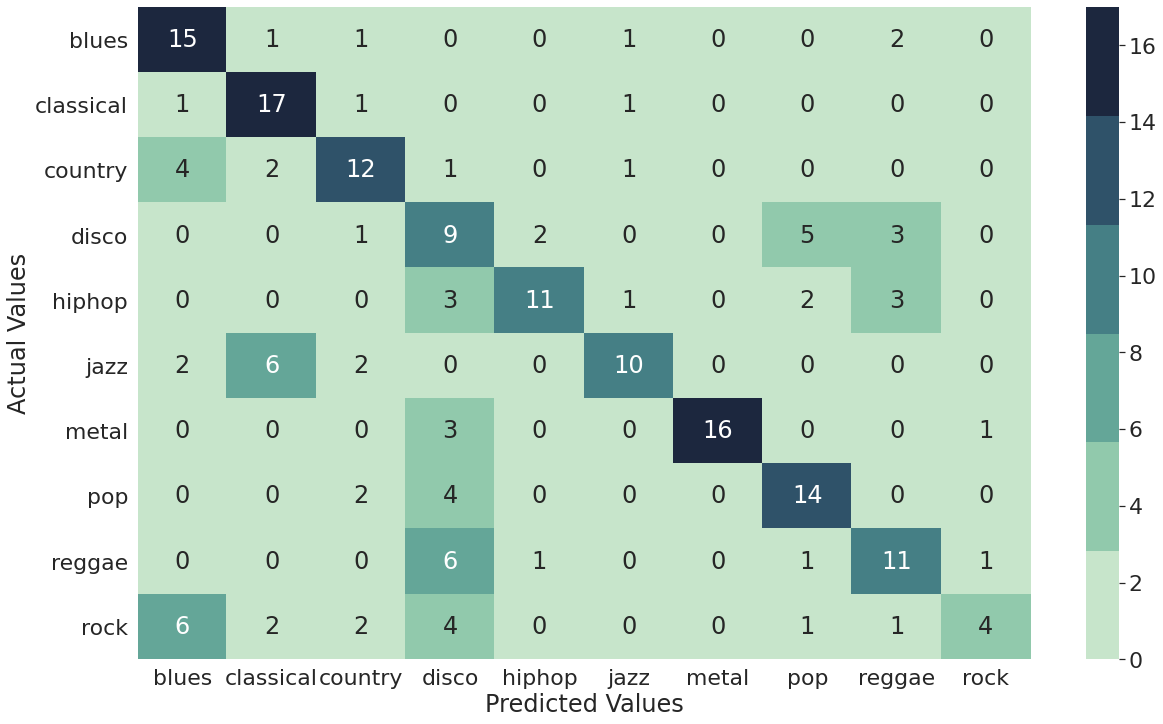

In [ ]:
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(rot=-.4));
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, 1),  np.argmax(predictions, 1)))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        20
           1       0.61      0.85      0.71        20
           2       0.57      0.60      0.59        20
           3       0.30      0.45      0.36        20
           4       0.79      0.55      0.65        20
           5       0.71      0.50      0.59        20
           6       1.00      0.80      0.89        20
           7       0.61      0.70      0.65        20
           8       0.55      0.55      0.55        20
           9       0.67      0.20      0.31        20

    accuracy                           0.59       200
   macro avg       0.63      0.59      0.59       200
weighted avg       0.63      0.59      0.59       200

